In [1]:
from neural_priors.utils.data import Subject, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op


In [2]:
behavior = get_all_behavioral_data()

In [3]:
bids_folder = '/data/ds-neuralpriors'

load_data_via_tsv = True

In [21]:
from neural_priors.utils.data import Subject
from tqdm.contrib.itertools import product

if load_data_via_tsv:
    df = pd.read_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t',
                    index_col=[0, 1, 2, 3, 4],
                    dtype={'subject':str})

    df.index.set_names('voxel', level=-1, inplace=True)
else:
    df = []
    keys = []
    subjects = [f'{subject:02d}' for subject in range(1, 20)]
    subjects.pop(subjects.index('11'))
    subjects.pop(subjects.index('16'))

    for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None, 'wide2'], [None], [True, False]):
    # for subject, range_n, session, smoothed in product(subjects, ['wide', 'narrow', None], [None], [True, False]):
        sub = Subject(subject, bids_folder)
        df.append(sub.get_prf_parameters_volume(session=session, cross_validated=False, roi='NPCr', smoothed=smoothed, range_n=range_n))
        keys.append((subject,
                    range_n if range_n is not None else 'both', session if session is not None else 'both',
                    'smoothed' if smoothed else 'unsmoothed'))

    df = pd.concat(df, keys=keys, names=['subject', 'range_n', 'session', 'smoothed'])
    df.to_csv(op.join(bids_folder, 'derivatives', 'encoding_model', 'npcr_parameters.tsv'), sep='\t')

df = df.unstack('range_n')

In [22]:
for c in df['mode'].columns:

    mode = df[('mode', c)]
    fwhm = df[('fwhm', c)]

    df[('log_sigma', c)] = 1./(np.sqrt(2.*np.log(2.))) * np.arcsinh(fwhm/(mode*2.))
    df[('log(mode)', c)] = np.log(mode)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
df.stack('range_n').groupby(['smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean())

smoothed    range_n
smoothed    both       0.194346
            narrow     0.129942
            wide       0.170156
            wide2      0.026986
unsmoothed  both       0.100688
            narrow     0.076121
            wide       0.101671
            wide2      0.017991
dtype: float64

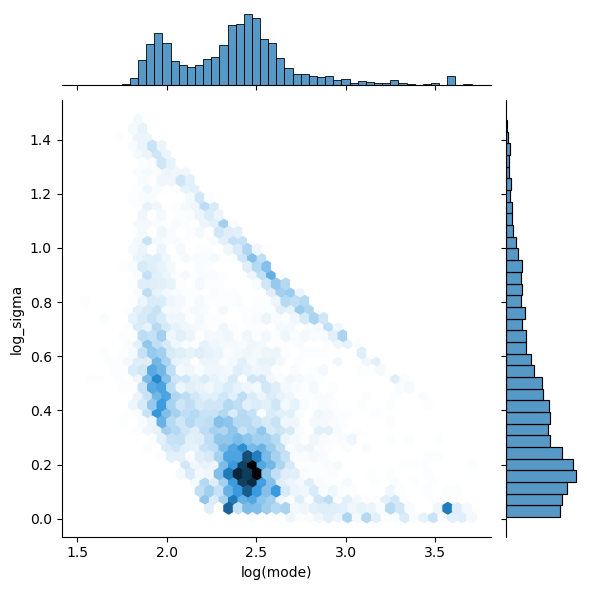

In [61]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp.reset_index(), kind='hex')

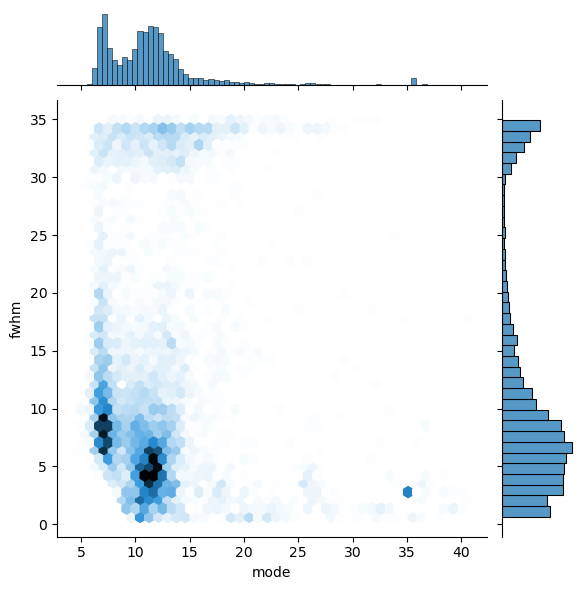

In [62]:
tmp = df.stack('range_n')
tmp = tmp[tmp.cvr2 > 0.01]
sns.jointplot(x='mode', y='fwhm', data=tmp.reset_index(), kind='hex')

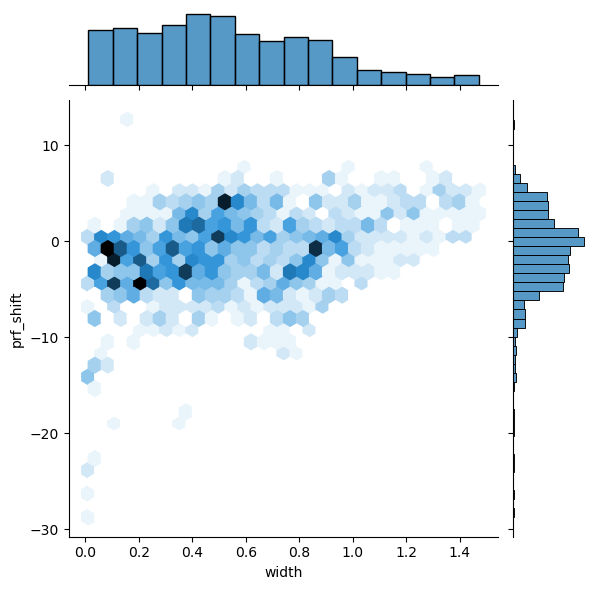

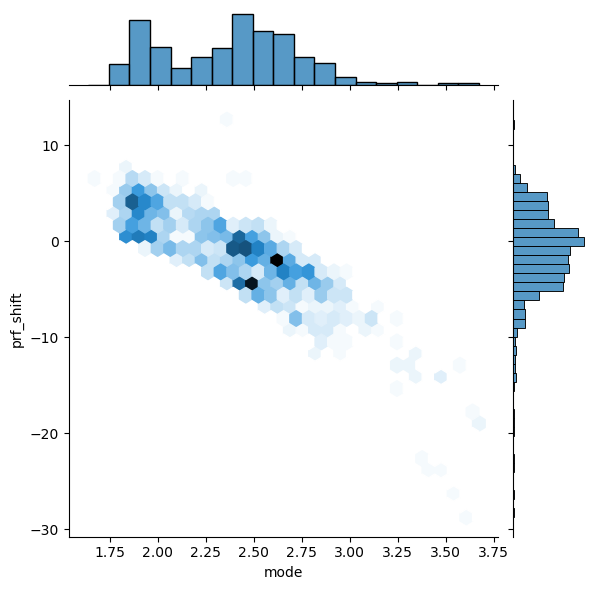

In [89]:
mask = (df[[('cvr2', 'wide'), ('cvr2', 'narrow')]].mean(1) > 0.01) & (df[('mode', 'narrow')] < 25)
prf_shift = df.loc[mask, ('mode', 'narrow')] - df.loc[mask, ('mode', 'wide')]

tmp = prf_shift.to_frame('prf_shift').join(df[('log_sigma', 'wide')].to_frame('width'))
tmp = tmp.join(df[('log(mode)', 'wide')].to_frame('mode'))

sns.jointplot(y='prf_shift', x='width', data=tmp.reset_index(), kind='hex')
sns.jointplot(y='prf_shift', x='mode', data=tmp.reset_index(), kind='hex')

n         r           CI95%     p-val   BF10     power
range                                                                  
narrow pearson  17 -0.169882    [-0.6, 0.34]  0.514495  0.365  0.100135
wide   pearson  17 -0.603690  [-0.84, -0.17]  0.010287  6.254  0.763771

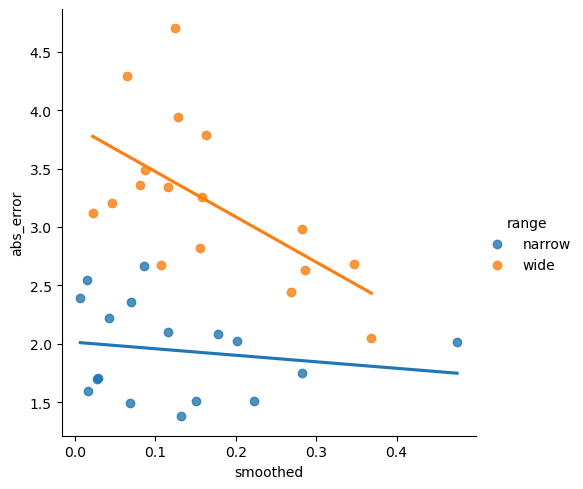

In [92]:
import pingouin as pg
r2 = df.stack('range_n').groupby(['subject', 'session', 'smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('smoothed')

r2.index.set_names('range', level='range_n', inplace=True)

tmp = behavior.groupby(['subject', 'range'])[['abs_error']].mean().join(r2.loc[])

sns.lmplot(x='smoothed', y='abs_error', hue='range', data=tmp.reset_index(), ci=None)

tmp.groupby(['range']).apply(lambda d: pg.corr(d['abs_error'], d['smoothed'], method='pearson'))

n         r          CI95%     p-val   BF10     power
pearson  17 -0.463222  [-0.77, 0.02]  0.061122  1.518  0.485282

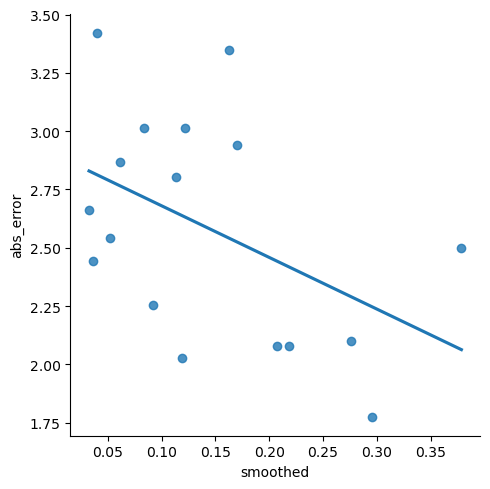

In [121]:
import pingouin as pg
r2 = df.stack('range_n').groupby(['subject', 'session', 'smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('smoothed')

r2.index.set_names('range', level='range_n', inplace=True)

tmp = behavior.groupby(['subject'])[['abs_error']].mean().join(r2.loc[(slice(None), 'both', ['narrow', 'wide'])].groupby('subject').mean())

sns.lmplot(x='smoothed', y='abs_error', data=tmp.reset_index(), ci=None)

pg.corr(tmp['abs_error'], tmp['smoothed'], method='pearson')

n         r          CI95%     p-val   BF10     power
pearson  17 -0.432905  [-0.76, 0.06]  0.082616  1.208  0.427672

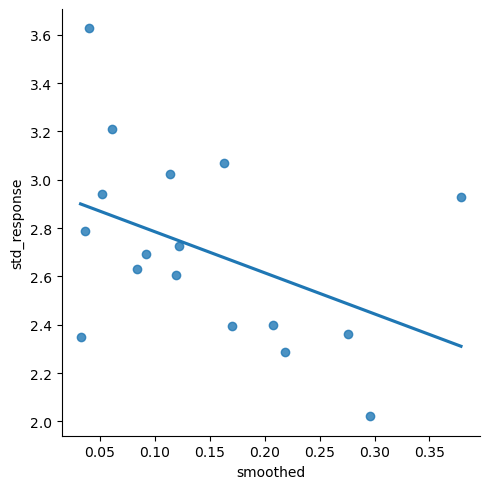

In [130]:
# behavior.grouimport pingouin as pg
r2 = df.stack('range_n').groupby(['subject', 'session', 'smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('smoothed')

r2.index.set_names('range', level='range_n', inplace=True)

tmp = behavior.groupby(['subject', 'n', 'range'])[['response']].std().groupby('subject').mean().join(r2.loc[(slice(None), 'both', ['narrow', 'wide'])].groupby('subject').mean())

tmp.rename(columns={'response': 'std_response'}, inplace=True)

sns.lmplot(x='smoothed', y='std_response', data=tmp.reset_index(), ci=None)

pg.corr(tmp['std_response'], tmp['smoothed'], method='pearson')

In [113]:
r2 = df.stack('range_n').groupby(['subject', 'session', 'smoothed', 'range_n']).apply(lambda d: (d['cvr2'] > 0.0).mean()).unstack('smoothed')

r2.index.set_names('range', level='range_n', inplace=True)

tmp = behavior.groupby(['subject', 'n', 'range'])['response'].std().groupby('subject').mean()
tmp.name = 'std responses'

r2.join(r2)

smoothed                smoothed  unsmoothed
subject session range                       
01      both    both    0.066148    0.035019
                narrow  0.042802    0.023346
                wide    0.022049    0.047990
                wide2   0.002594    0.009079
02      both    both    0.073256    0.040698
...                          ...         ...
18      both    wide2   0.025469    0.006702
19      both    both    0.298876    0.178652
                narrow  0.150562    0.098876
                wide    0.286517    0.167416
                wide2   0.039326    0.023596

[68 rows x 2 columns]

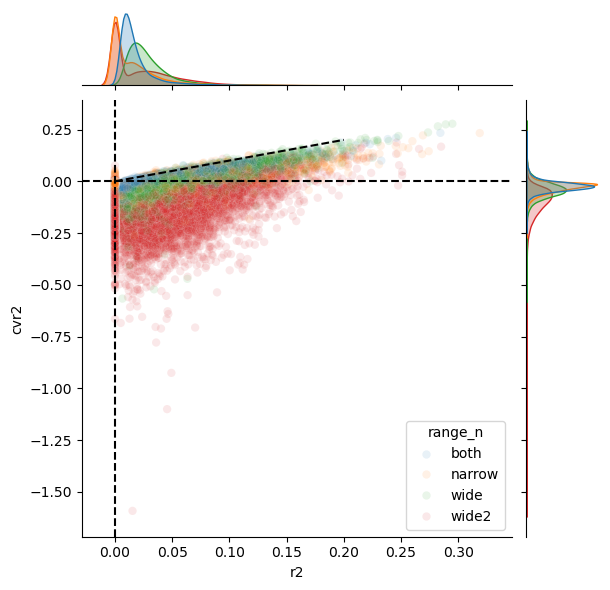

In [14]:
tmp = df.stack(1)


sns.jointplot(data=tmp, x='r2', y='cvr2', hue='range_n', alpha=0.1)
plt.axhline(0.0, c='k', ls='--')
plt.axvline(0.0, c='k', ls='--')
plt.plot([0, .2], [0, .2], c='k', ls='--')

In [15]:
df.groupby(['subject', 'session', 'smoothed']).apply(lambda d: (d[[('cvr2', 'wide'), ('cvr2', 'narrow')]] > 0.00).any(axis=1).mean()).unstack('smoothed')

smoothed         smoothed  unsmoothed
subject session                      
1       both     0.064851    0.068742
2       both     0.147674    0.086047
3       both     0.078431    0.065826
4       both     0.207742    0.172903
5       both     0.103397    0.128508
6       both     0.221118    0.124224
7       both     0.413677    0.176009
8       both     0.276730    0.133648
9       both     0.282575    0.145997
10      both     0.072678    0.092867
12      both     0.524719    0.343820
13      both     0.428404    0.274648
14      both     0.175000    0.118750
15      both     0.392904    0.180026
17      both     0.215385    0.187179
18      both     0.121984    0.084450
19      both     0.330337    0.211236

In [281]:
df.groupby(['subject', 'session', 'smoothed']).apply(lambda d: (d[[('cvr2', 'wide'), ('cvr2', 'narrow')]] > 0.00).all(axis=1).mean()).unstack('smoothed')

smoothed         smoothed  unsmoothed
subject session                      
1       both     0.000000    0.002594
2       both     0.019767    0.004651
3       both     0.001401    0.004202
4       both     0.019355    0.019355
5       both     0.000000    0.005908
6       both     0.017391    0.002484
7       both     0.137892    0.038117
8       both     0.048742    0.007862
9       both     0.058085    0.021978
10      both     0.000000    0.002692
12      both     0.232584    0.085393
13      both     0.163146    0.059859
14      both     0.008750    0.003750
15      both     0.022339    0.015769
17      both     0.028205    0.010256
18      both     0.000000    0.000000
19      both     0.106742    0.055056

# Narrow vs wide

In [288]:
# Let's filter out anything where the cross-validated  is less 0 for both ranges combined
# tmp = df.stack(['subject'])
# Make sure subject is first index

# set order of index
tmp = df.copy().droplevel(-1).reorder_levels(['subject', 'session', 'smoothed']).sort_index()
tmp = tmp[(tmp[[('cvr2', 'wide'), ('cvr2', 'narrow')]] > 0.00).any(axis=1)]
tmp = tmp[(tmp[[('r2', 'wide'), ('r2', 'narrow')]] > 0.01).all(axis=1)]

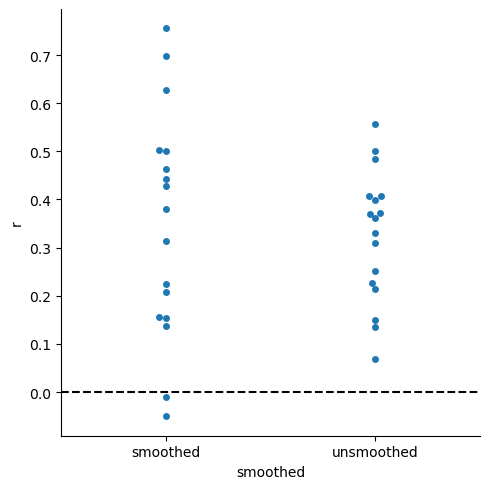

In [289]:
import pingouin as pg
r = tmp.groupby(['subject', 'smoothed']).apply(lambda d: pg.corr(d[('mode', 'narrow')], d[('mode', 'wide')]))


sns.catplot(x='smoothed', y='r', data=r.reset_index(), kind='swarm')
plt.axhline(0.0, c='k', ls='--')

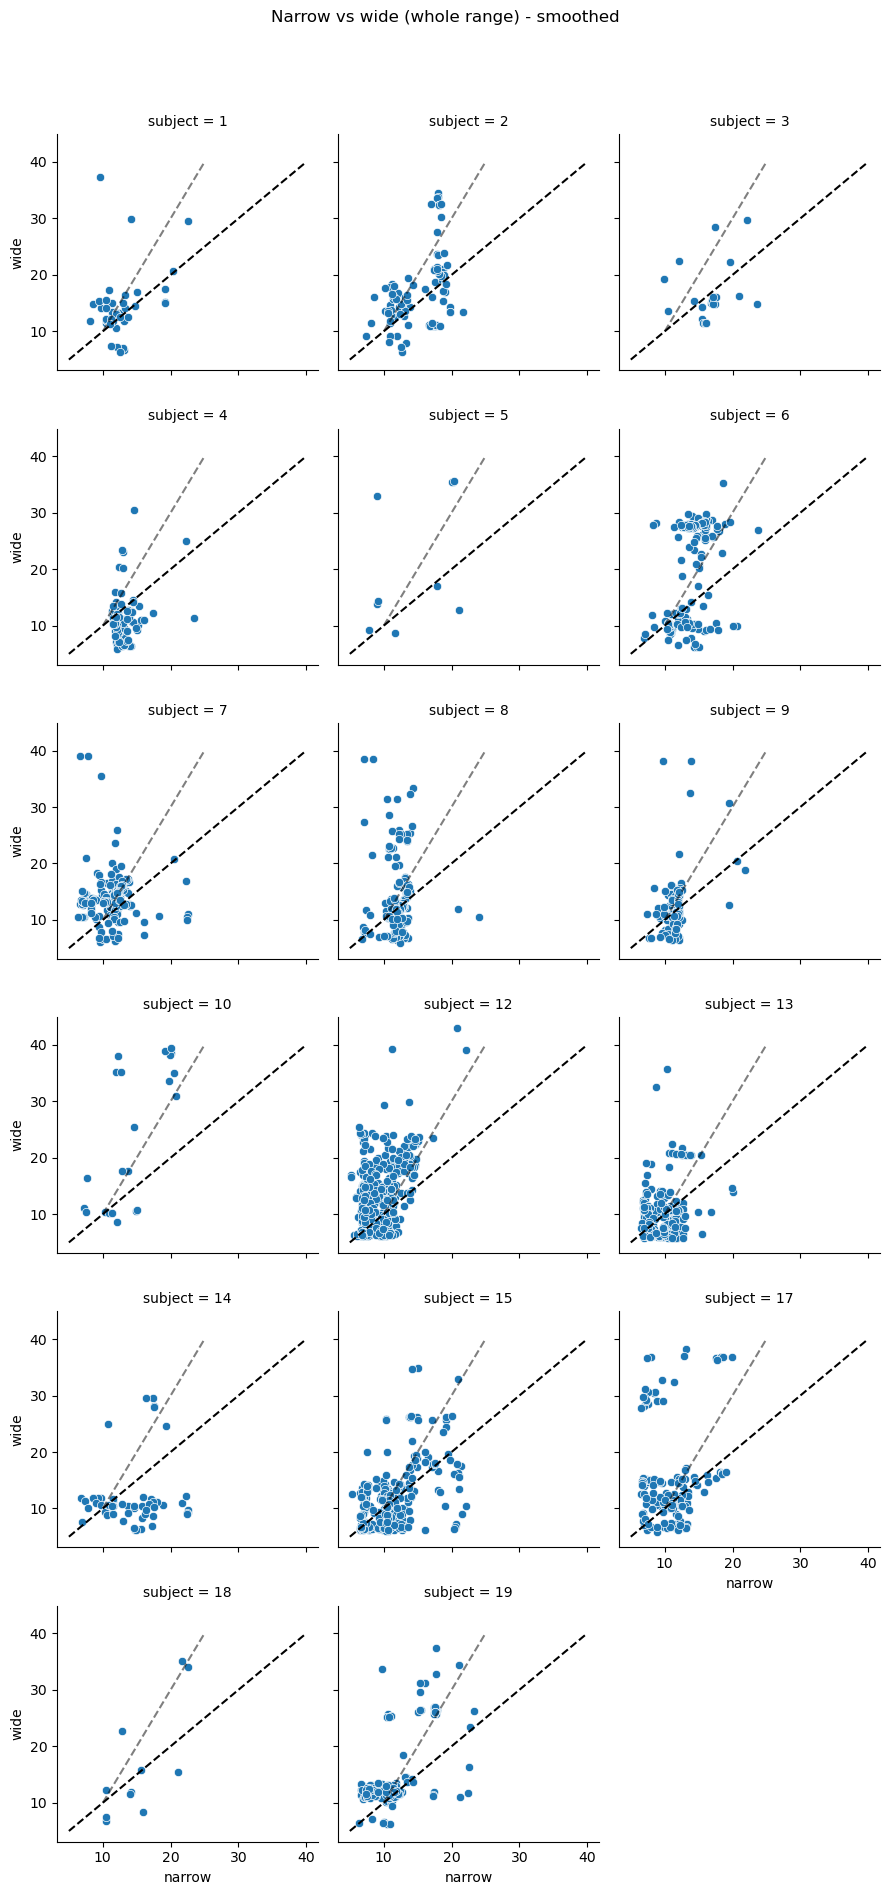

<Figure size 640x480 with 0 Axes>

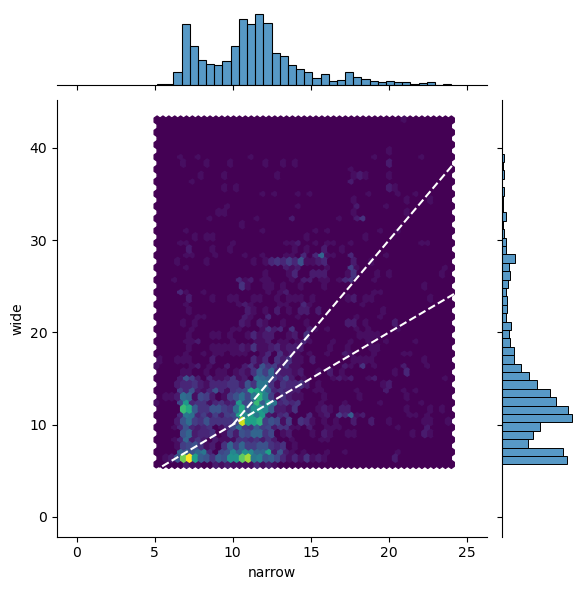

In [284]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')
    ax.plot([10, 25], [10, 40], color='black', linestyle='--', alpha=0.5)


g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([0, 25], [0, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

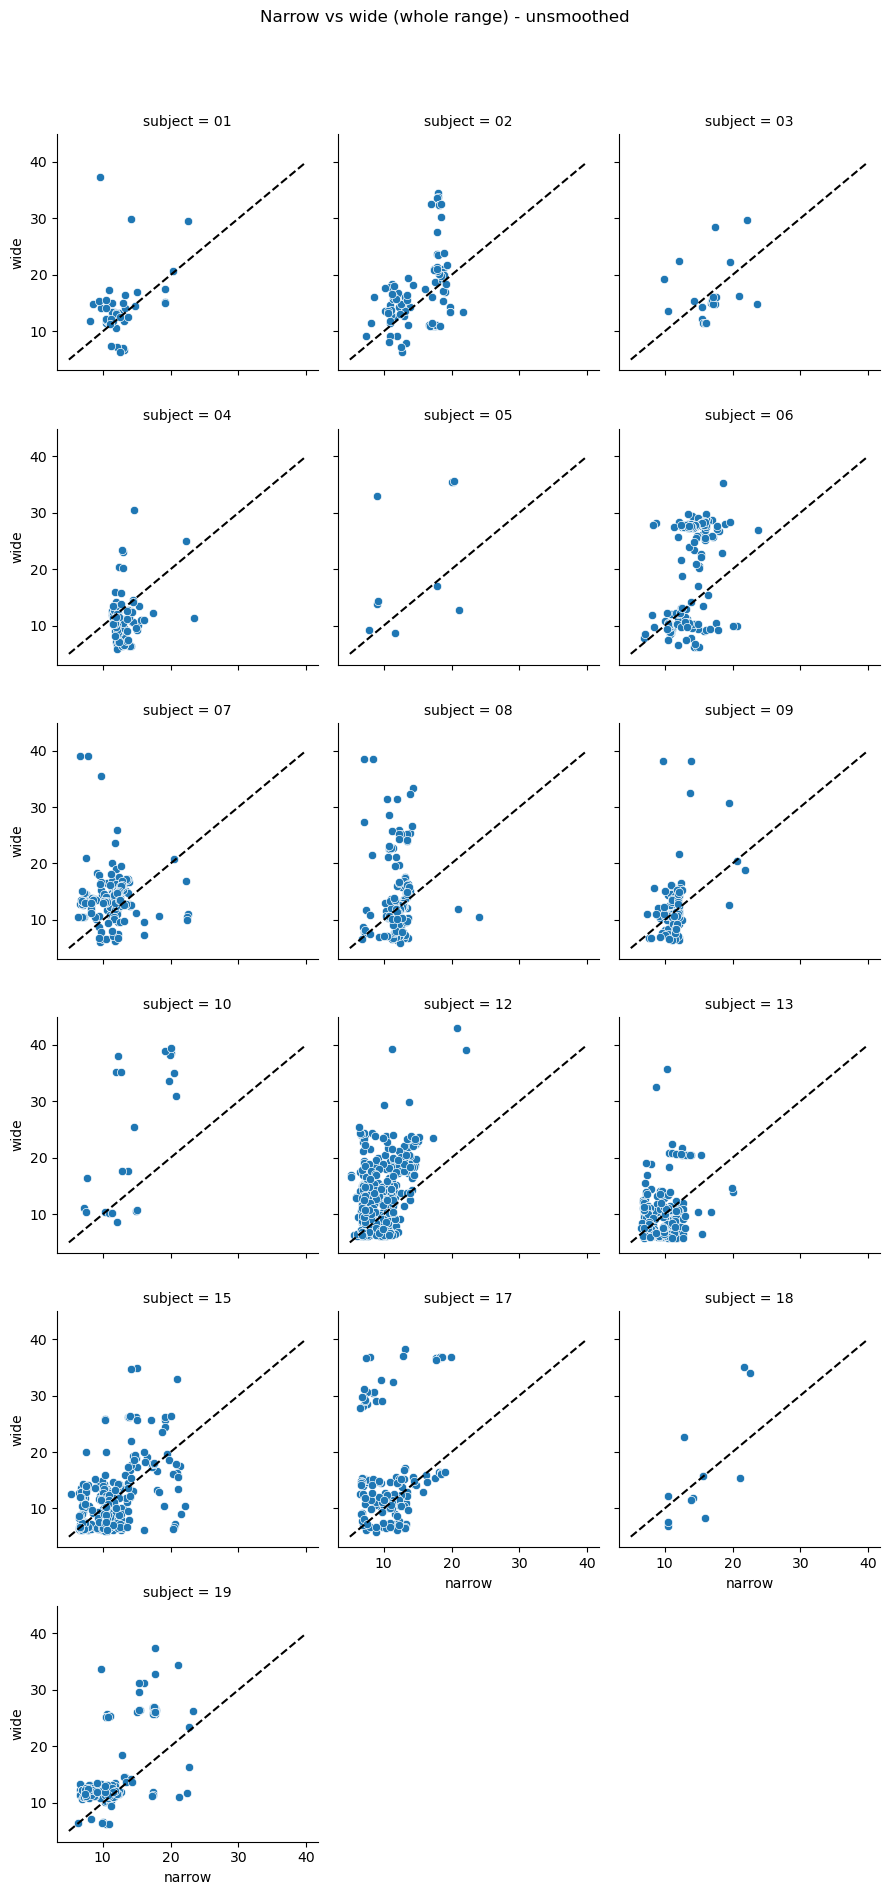

<Figure size 640x480 with 0 Axes>

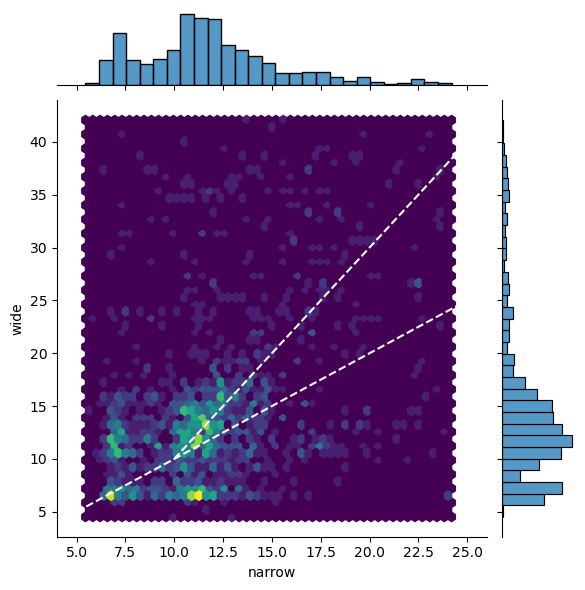

In [236]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - unsmoothed', y=1.05)

plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([5, 25], [5, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

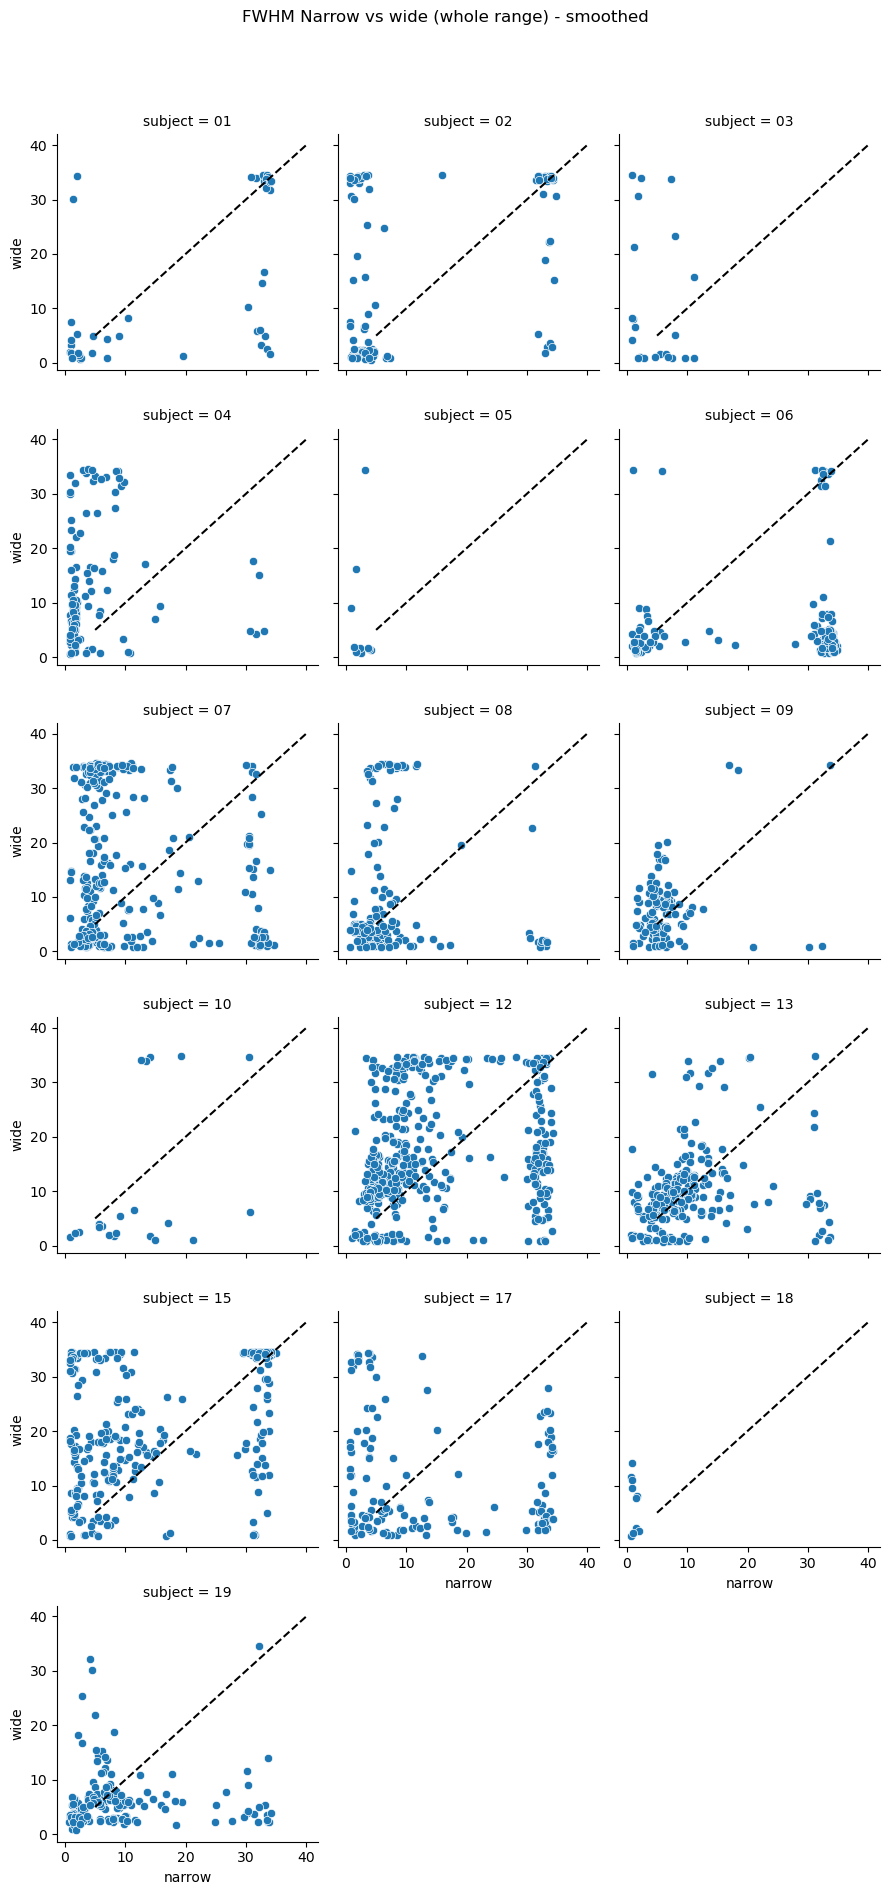

<Figure size 640x480 with 0 Axes>

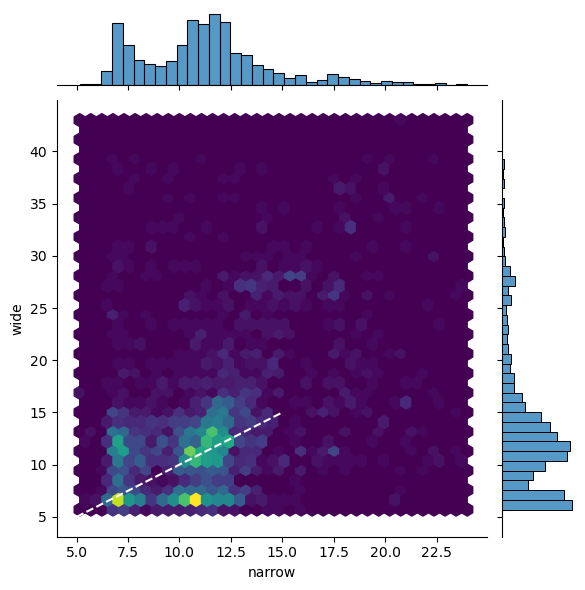

In [240]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['fwhm'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('FWHM Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([5, 15], [5, 15], color='white', linestyle='--')

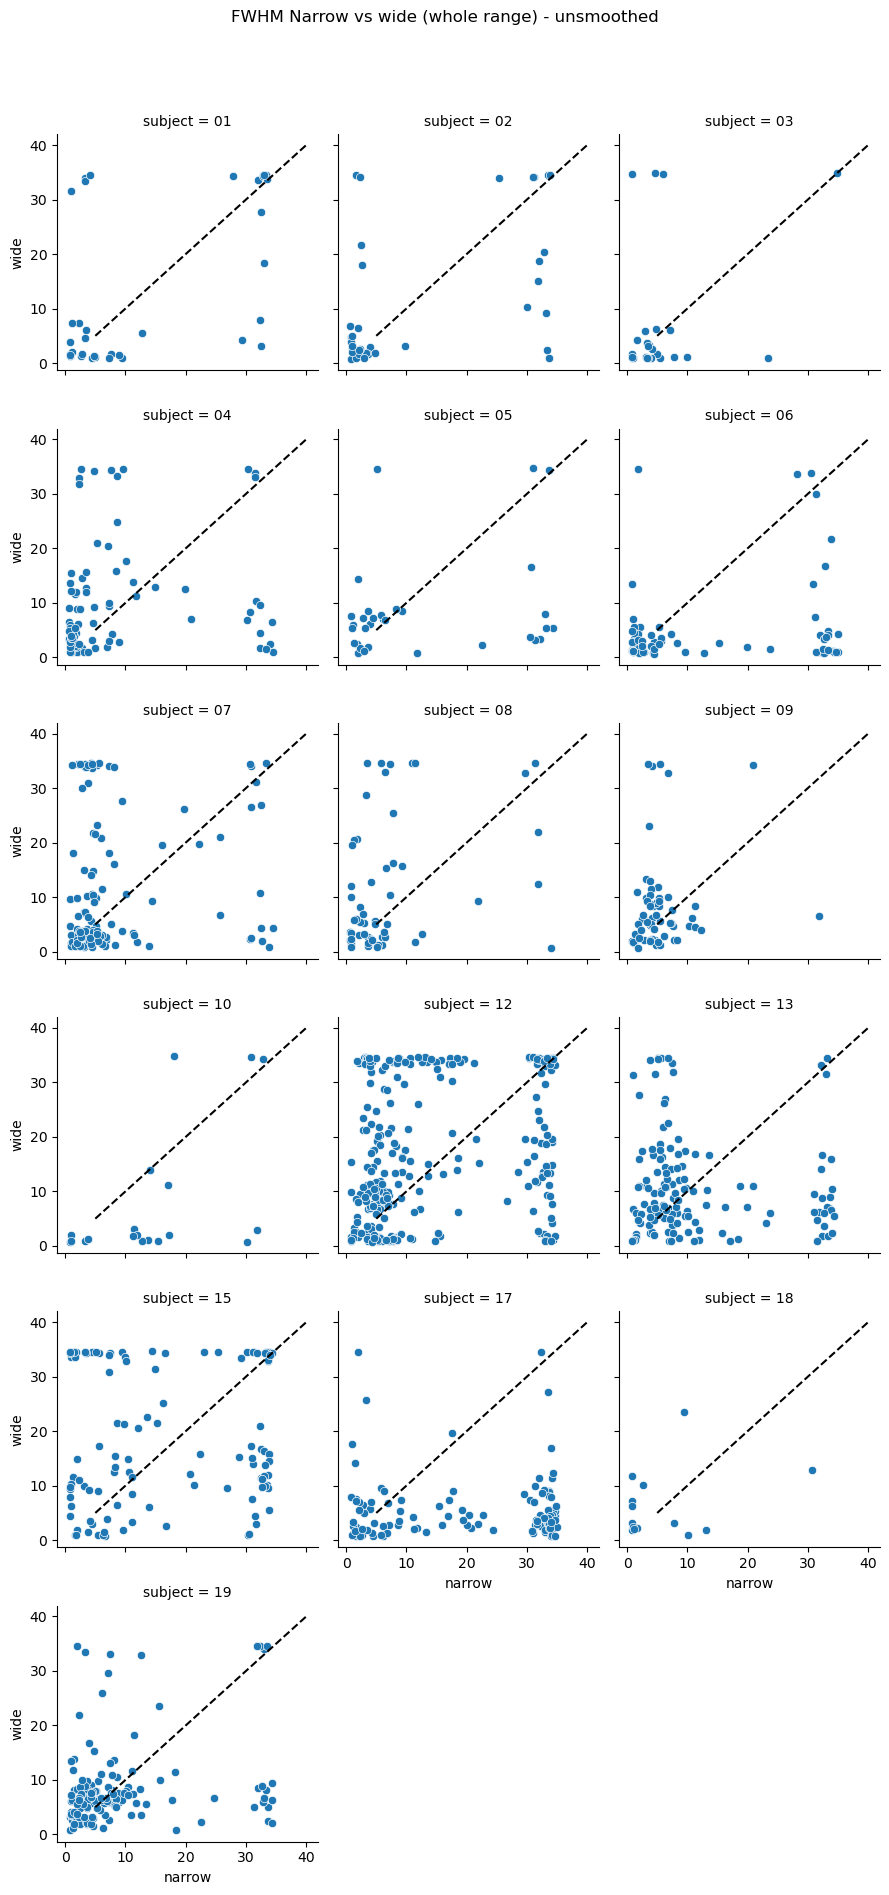

<Figure size 640x480 with 0 Axes>

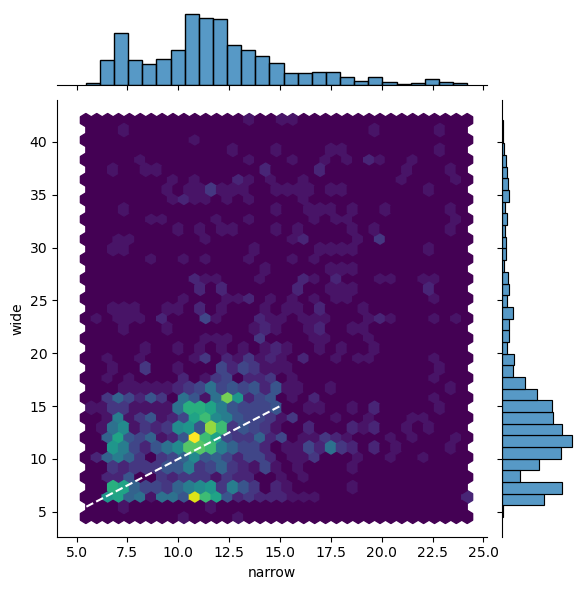

In [241]:
g = sns.FacetGrid(tmp.xs('unsmoothed', 0, 'smoothed')['fwhm'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('FWHM Narrow vs wide (whole range) - unsmoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([5, 15], [5, 15], color='white', linestyle='--')

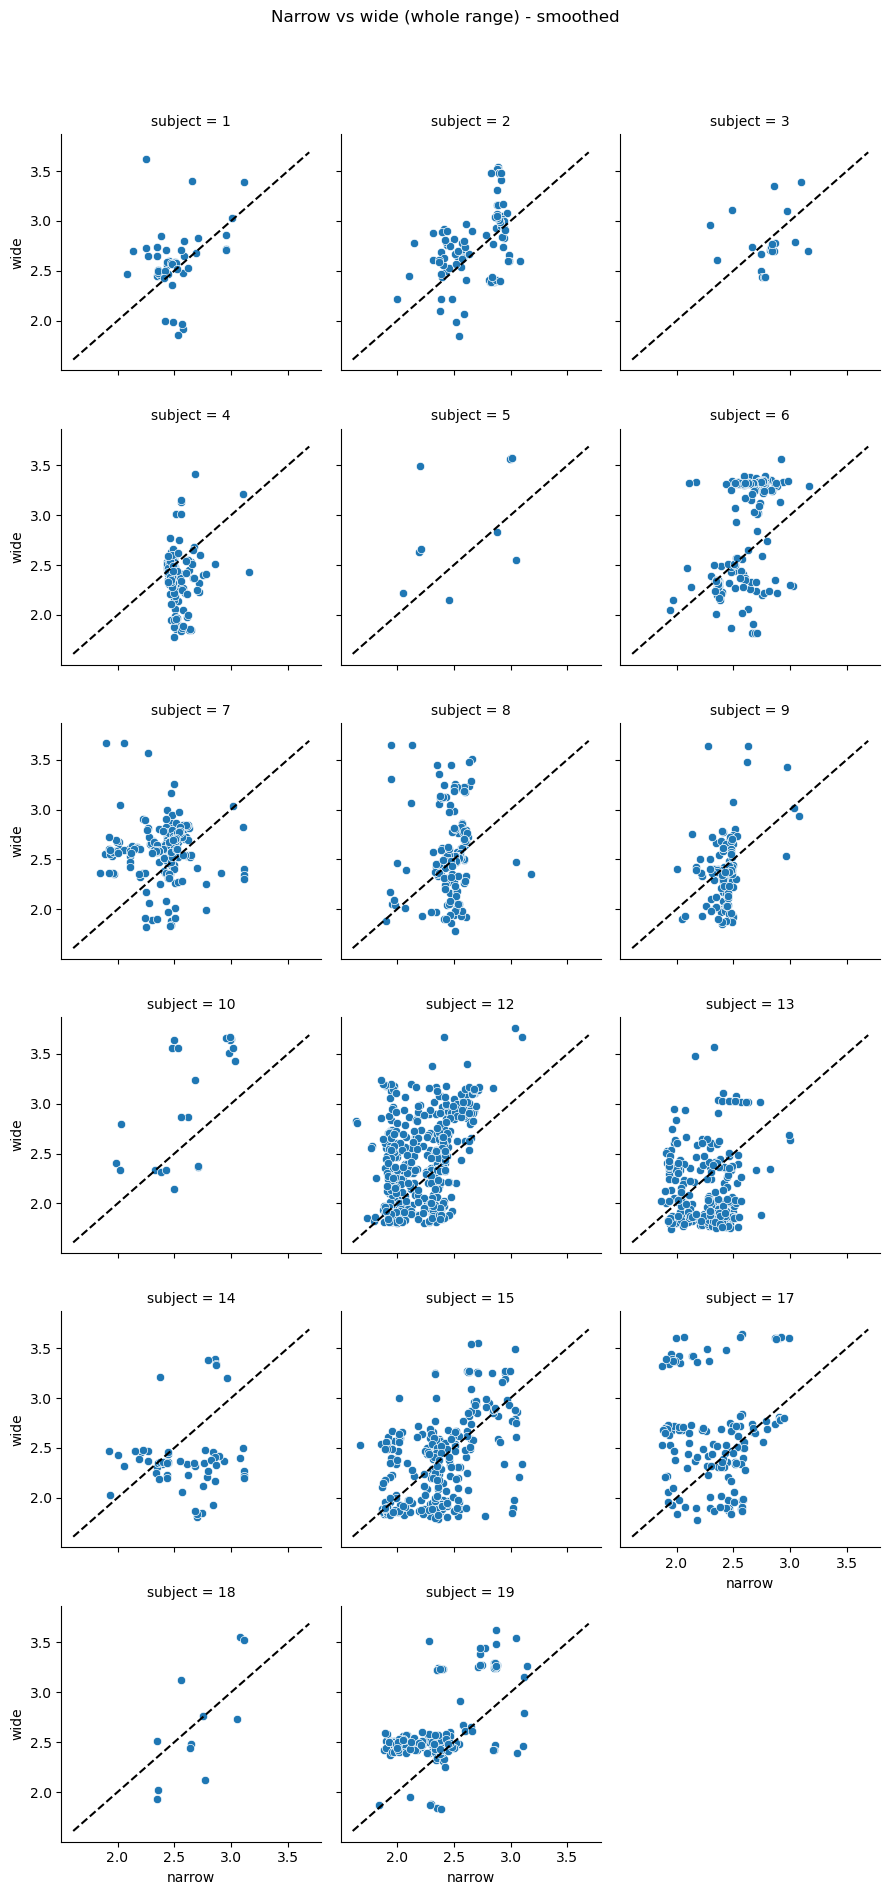

<Figure size 640x480 with 0 Axes>

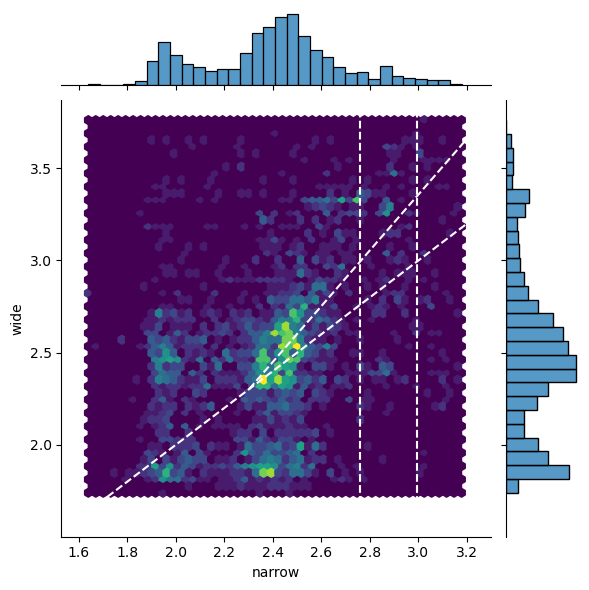

In [290]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['log(mode)'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([np.log(5), np.log(40)], [np.log(5), np.log(40)], color='black', linestyle='--')
#     ax.plot([10, 25], [10, 40], color='black', linestyle='--', alpha=0.5)


g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['log(mode)'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=50)
plt.plot([np.log(5), np.log(25)], [np.log(5), np.log(25)], color='white', linestyle='--')
plt.plot([np.log(10), np.log(25)], [np.log(10), np.log(40)], color='white', linestyle='--')

plt.axvline((np.log(25) + np.log(10))/2., c='w', ls='--')
plt.axvline((np.log(40) + np.log(10))/2., c='w', ls='--')

In [302]:
tmp

mode                                   \
range_n                          both     narrow       wide      wide2   
subject session smoothed                                                 
1       both    smoothed    12.172480  11.611625  13.386742  13.418047   
                smoothed    12.698802  12.213608  13.271726  13.358773   
                smoothed    12.873496  13.112425  11.863932  11.881220   
                smoothed     9.904907   8.053582  11.814313  35.423730   
                smoothed    12.020999  11.377777  12.968081  12.784919   
...                               ...        ...        ...        ...   
19      both    unsmoothed   7.226266   8.571872  12.109248  35.423730   
                unsmoothed   8.847382  10.867309  11.759242  12.289331   
                unsmoothed  10.874976  10.683398  11.719621  11.941468   
                unsmoothed  12.274953  12.517249   6.639911  35.423730   
                unsmoothed   6.848986   6.107089   9.828615   9.889190   

                                 fwhm                                  \
range_n                          both     narrow       wide     wide2   
subject session smoothed                                                
1       both    smoothed     4.435317   2.057515   5.210950  6.381856   
                smoothed     5.346351   6.953415   4.314141  4.919535   
                smoothed     4.971232   6.893483   0.963688  1.031430   
                smoothed    10.949371  19.502280   1.261808  3.000000   
                smoothed     8.466207  10.366941   8.293757  5.640655   
...                               ...        ...        ...       ...   
19      both    unsmoothed   7.757696   4.267159   7.571213  3.000000   
                unsmoothed  14.092250   5.956622  11.029012  6.757614   
                unsmoothed   4.084589   2.239581   6.357706  3.925497   
                unsmoothed   3.740530   3.283956  33.543700  3.000000   
                unsmoothed   8.679326   5.894035   6.778586  6.342689   

                           amplitude            ...      cvr2            \
range_n                         both    narrow  ...      wide     wide2   
subject session smoothed                        ...                       
1       both    smoothed    0.617753  1.007284  ... -0.046444 -0.137451   
                smoothed    0.408456  0.457620  ... -0.013910 -0.168450   
                smoothed    0.404371  0.394111  ...  0.024929 -0.069706   
                smoothed    0.204331  0.516247  ... -0.066278 -0.272103   
                smoothed    0.277319  0.364961  ... -0.007783 -0.171566   
...                              ...       ...  ...       ...       ...   
19      both    unsmoothed  0.946546  0.949217  ...  0.016927 -0.018882   
                unsmoothed  1.487143  0.828267  ...  0.048506 -0.085903   
                unsmoothed  0.849981  0.908721  ... -0.013940 -0.143004   
                unsmoothed  0.423046  0.410817  ... -0.050504 -0.044426   
                unsmoothed  0.679140  0.800128  ...  0.003217 -0.027877   

                           log(mode)                               log_sigma  \
range_n                         both    narrow      wide     wide2      both   
subject session smoothed                                                       
1       both    smoothed    2.499178  2.452007  2.594265  2.596601  0.153891   
                smoothed    2.541508  2.502551  2.585636  2.592173  0.177493   
                smoothed    2.555171  2.573560  2.473503  2.474959  0.162985   
                smoothed    2.293030  2.086117  2.469312  3.567382  0.448328   
                smoothed    2.486655  2.431662  2.562491  2.548266  0.293222   
...                              ...       ...       ...       ...       ...   
19      both    unsmoothed  1.977722  2.148486  2.493969  3.567382  0.436429   
                unsmoothed  2.180122  2.385759  2.464639  2.508731  0.619887   
                unsmoothed  2.386464  2.36

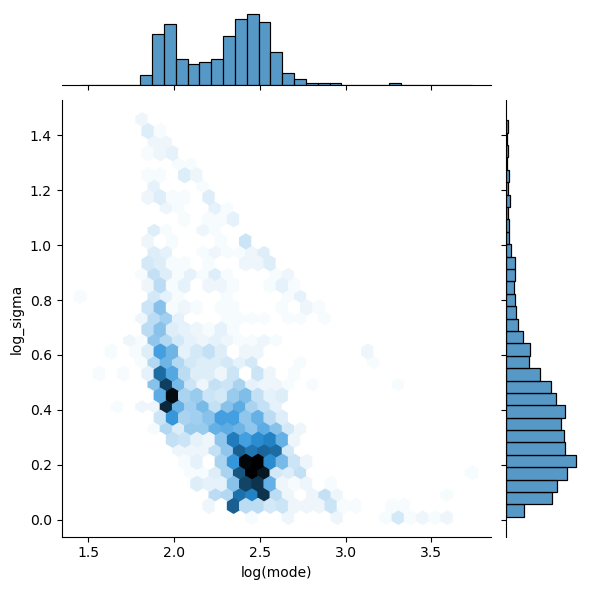

In [304]:
sns.jointplot(x='log(mode)', y='log_sigma', data=tmp[tmp[('cvr2', 'both')] > 0.0].xs('both', axis=1, level='range_n'), kind='hex')

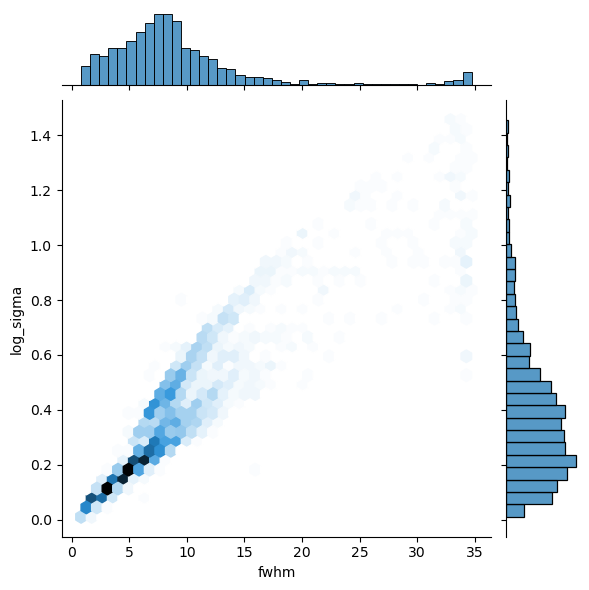

In [305]:
sns.jointplot(x='fwhm', y='log_sigma', data=tmp[tmp[('cvr2', 'both')] > 0.0].xs('both', axis=1, level='range_n'), kind='hex')

In [ ]:
mptmp

# Narrow vs wide 2

In [164]:
# Let's filter out anything where the cross-validated  is less 0 for both ranges combined
# tmp = df.stack(['subject'])
# Make sure subject is first index

# set order of index
tmp = df.copy().droplevel(-1).reorder_levels(['subject', 'session', 'smoothed']).sort_index()
# tmp = tmp[(tmp[('cvr2', 'both')] > 0.00)]
# tmp = tmp[tmp[[('cvr2', 'wide'), ('cvr2', 'narrow')]].mean(1) > 0.00]
tmp = tmp[(tmp[[('cvr2', 'wide2'), ('cvr2', 'narrow')]] > 0.00).any(axis=1)]

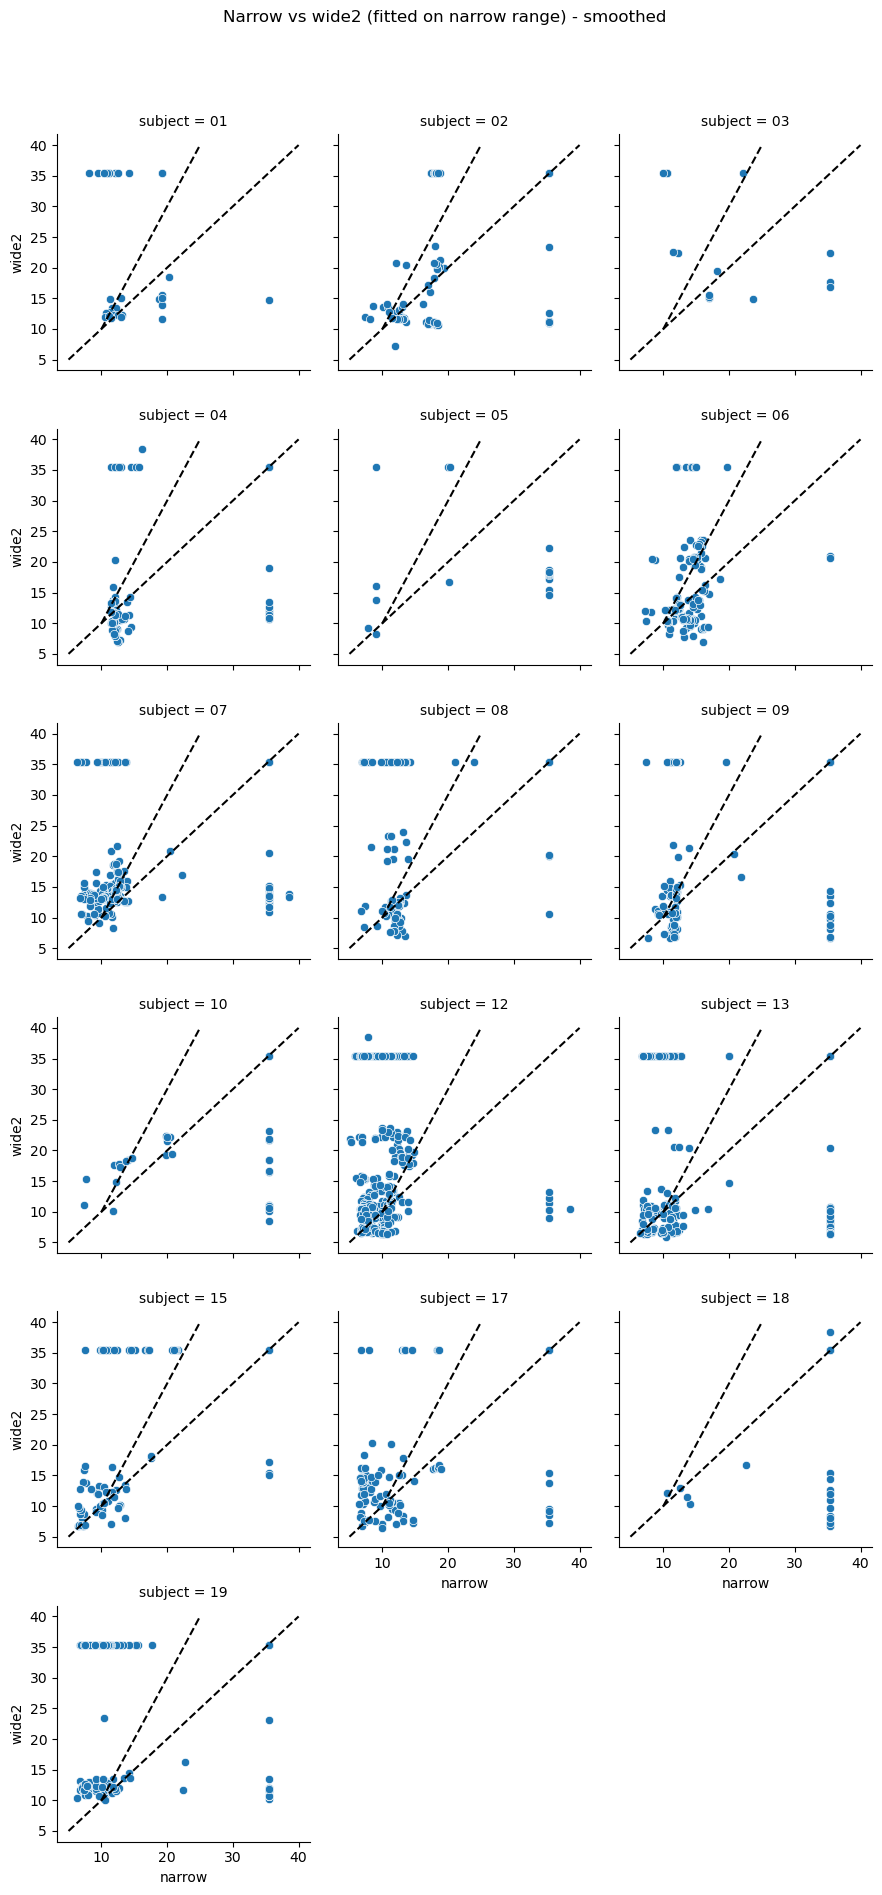

<Figure size 640x480 with 0 Axes>

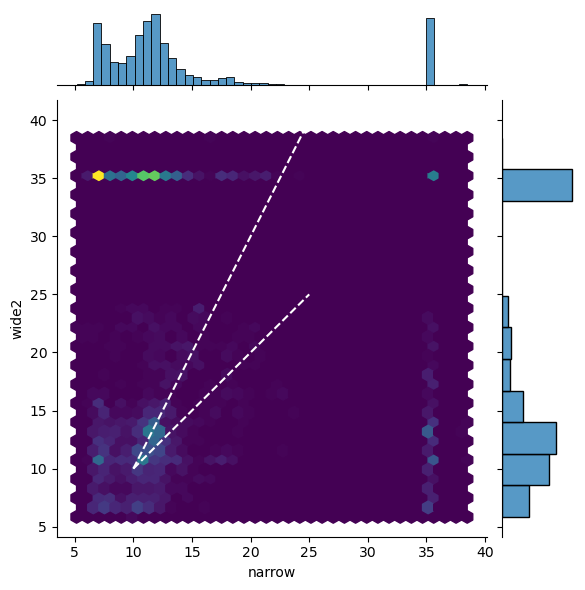

In [165]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide2')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')
    ax.plot([10, 25], [10, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide2 (fitted on narrow range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide2', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')
plt.plot([10, 25], [10, 40], color='white', linestyle='--')

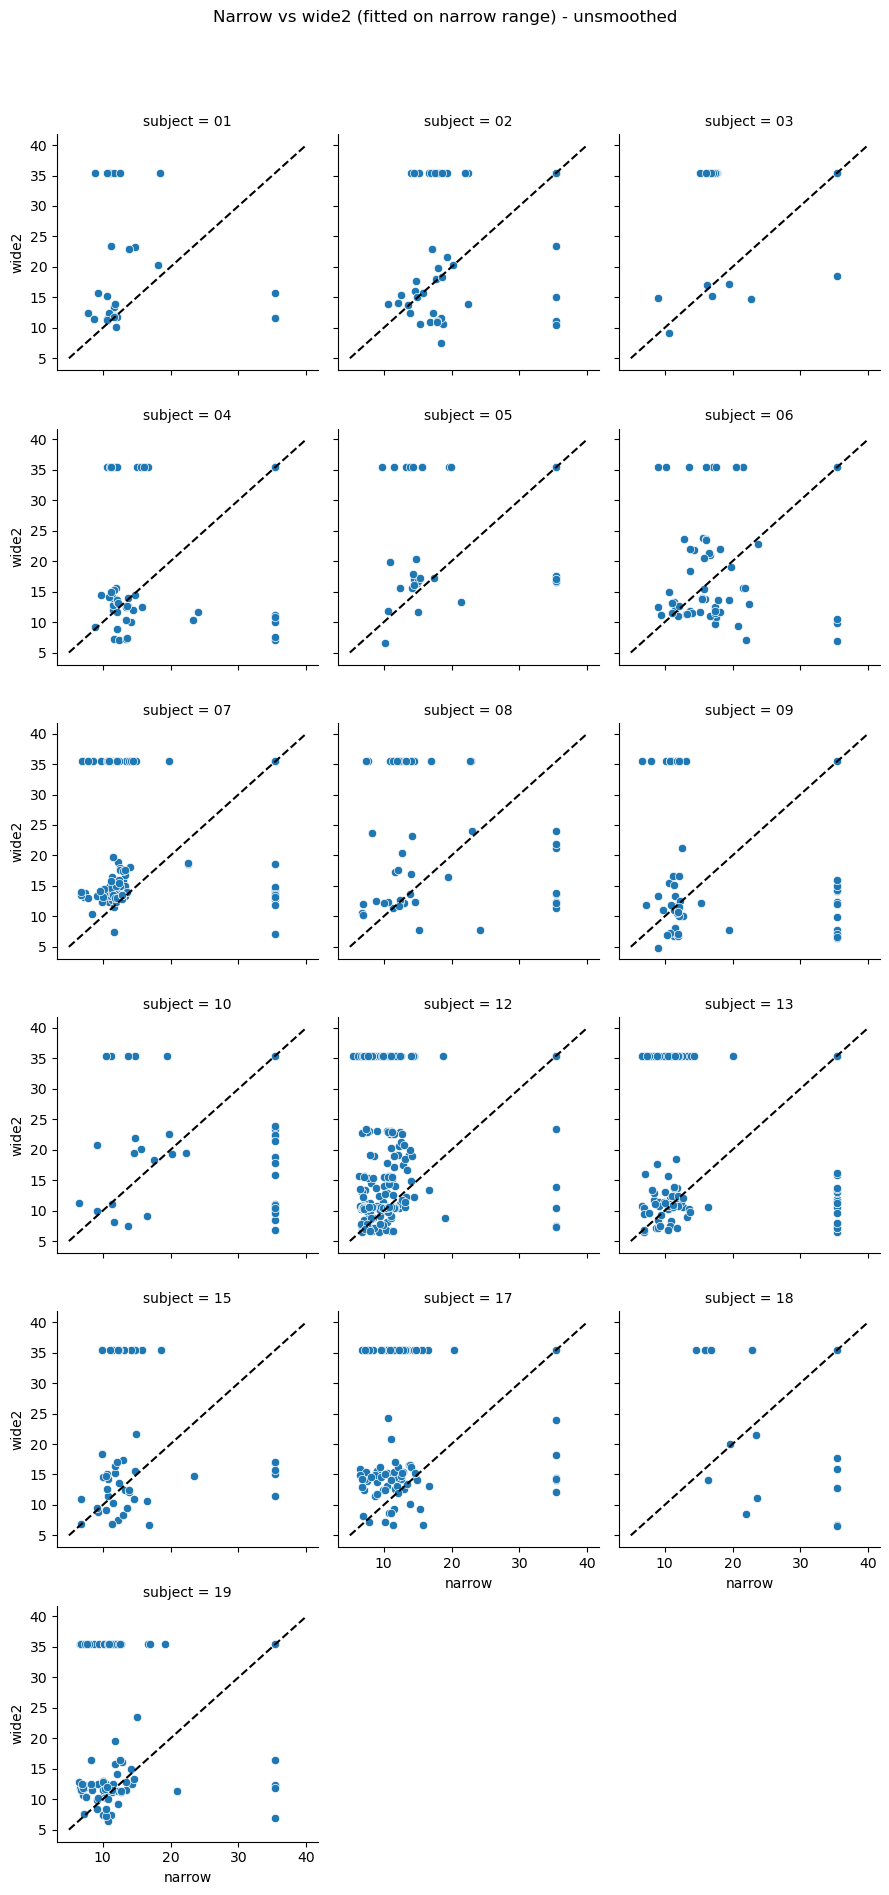

<Figure size 640x480 with 0 Axes>

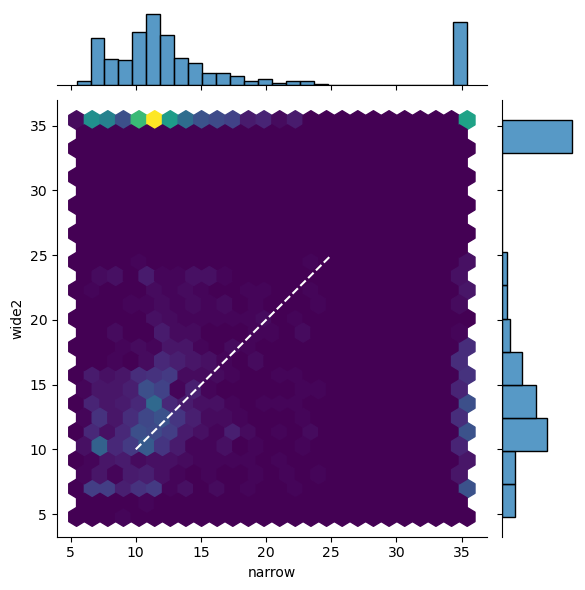

In [167]:
g = sns.FacetGrid(tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide2')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide2 (fitted on narrow range) - unsmoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide2', kind='hex', cmap='viridis',
              gridsize=25)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')

# Narrow vs wide (unfiltered)

In [84]:
# Let's filter out anything where the cross-validated  is less 0 for both ranges combined
# tmp = df.stack(['subject'])
# Make sure subject is first index

# set order of index
tmp = df.copy().droplevel(-1).reorder_levels(['subject', 'session', 'smoothed']).sort_index()
tmp = tmp[(tmp[('cvr2', 'both')] > 0.00)]
# tmp = tmp[tmp[[('cvr2', 'wide'), ('cvr2', 'narrow')]].mean(1) > 0.00]
# tmp = tmp[(tmp[[('cvr2', 'wide2/'), ('cvr2', 'narrow')]] > 0.00).any(axis=1)]

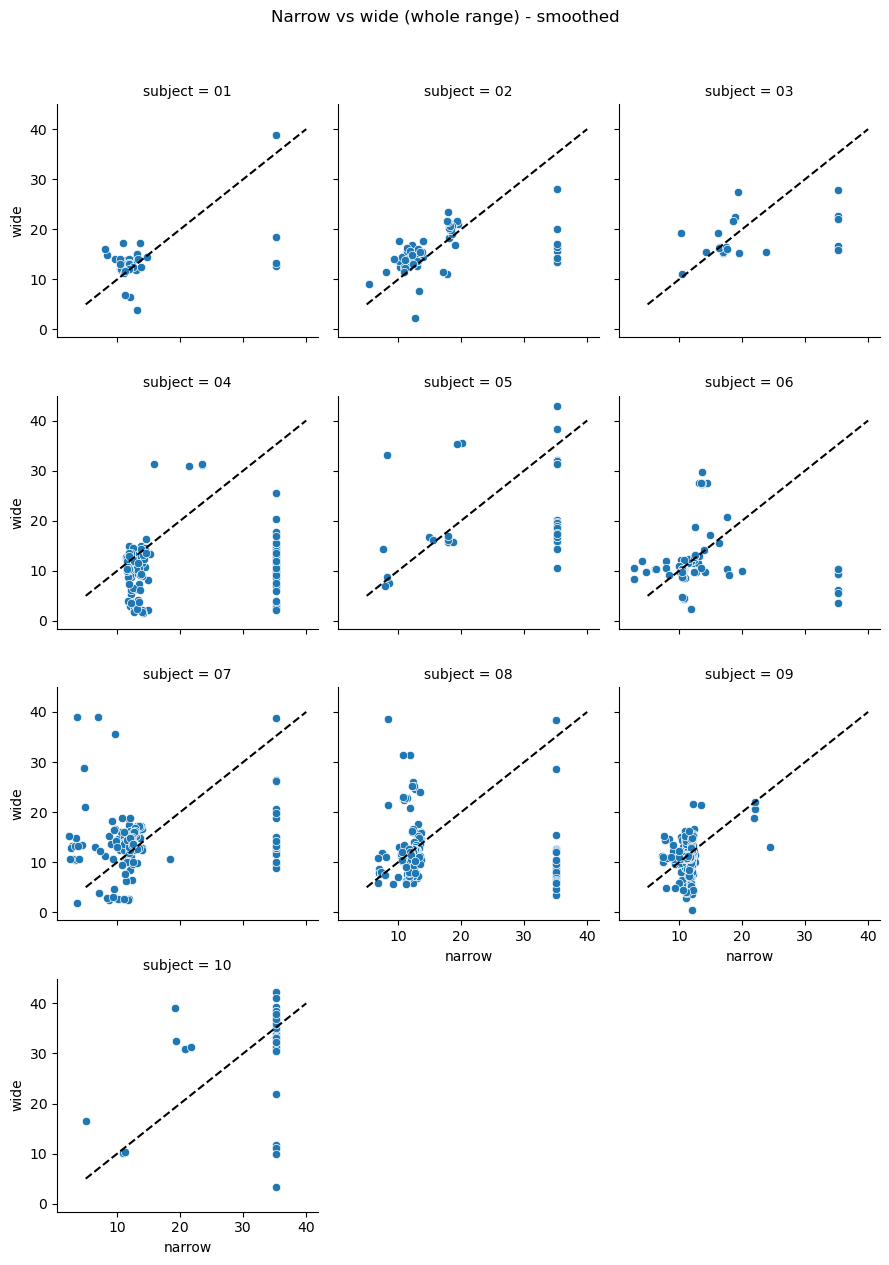

<Figure size 640x480 with 0 Axes>

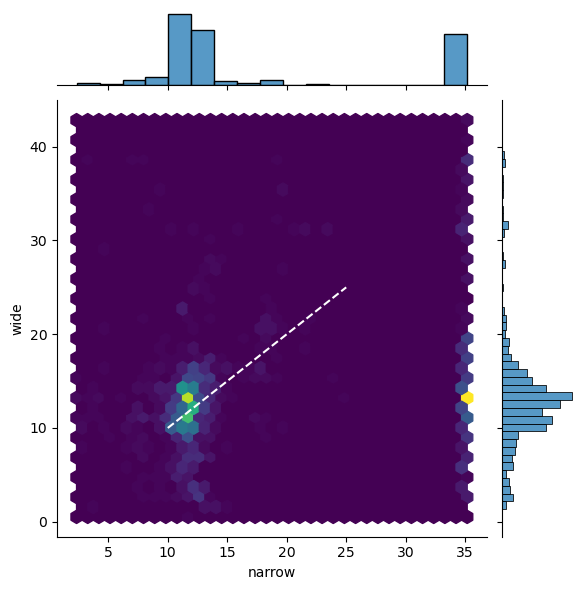

In [86]:
g = sns.FacetGrid(tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - smoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('smoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')

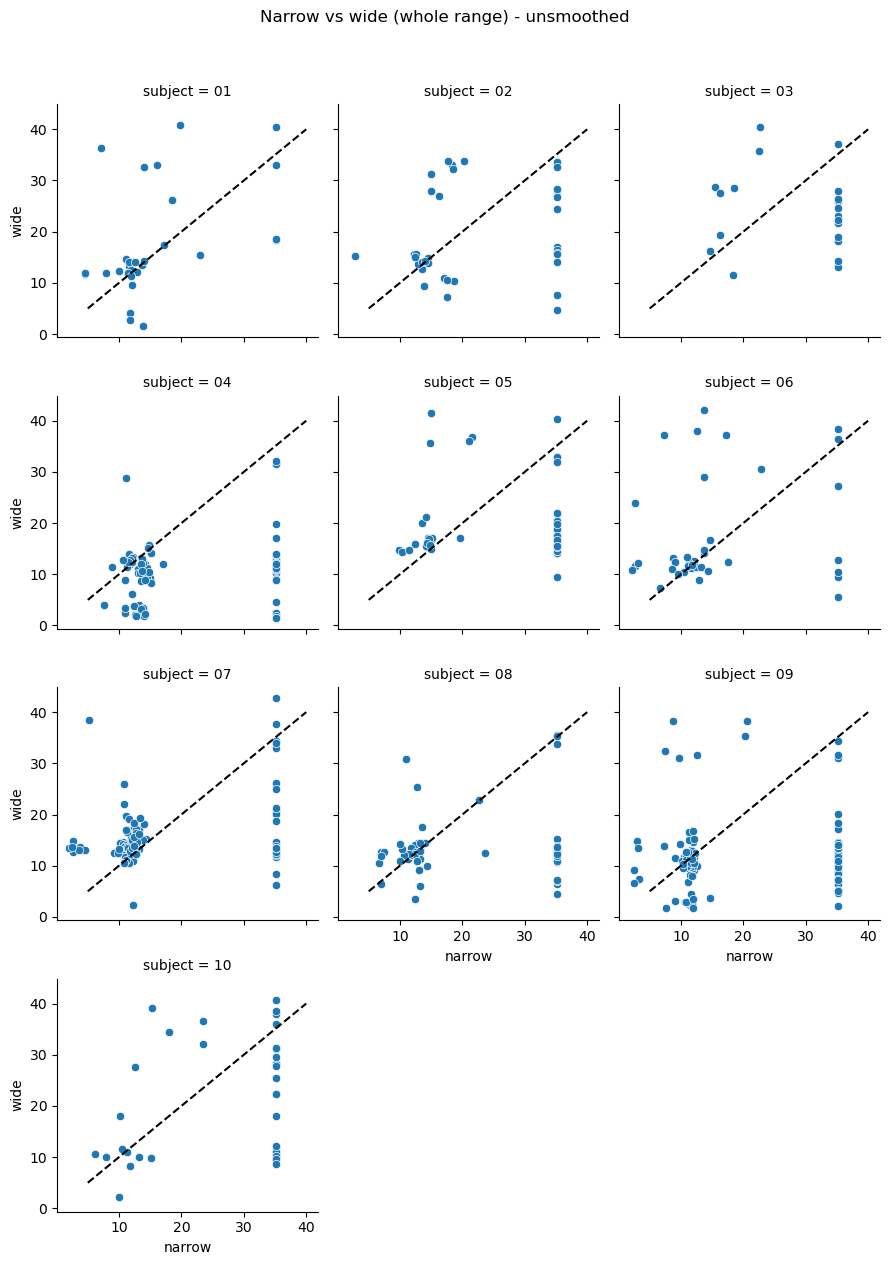

<Figure size 640x480 with 0 Axes>

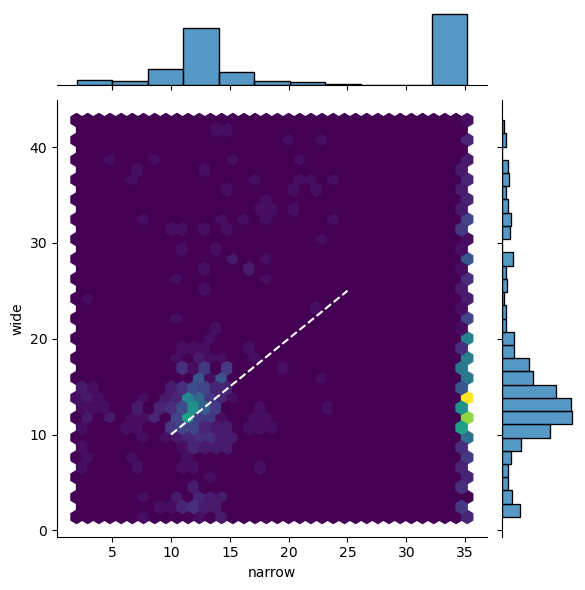

In [88]:
g = sns.FacetGrid(tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), col='subject', col_wrap=3)

g.map(sns.scatterplot, 'narrow', 'wide')
for ax in g.axes.flat:
    ax.plot([5, 40], [5, 40], color='black', linestyle='--')


g.fig.suptitle('Narrow vs wide (whole range) - unsmoothed', y=1.05)
plt.figure()

sns.jointplot(data=tmp.xs('unsmoothed', 0, 'smoothed')['mode'].reset_index(), x='narrow', y='wide', kind='hex', cmap='viridis',
              gridsize=35)
plt.plot([10, 25], [10, 25], color='white', linestyle='--')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51312/1278145697.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp[('mode', 'narrow')])
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51312/1278145697.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(tmp[('mode', 'w

<Axes: xlabel="('mode', 'wide')", ylabel='Density'>

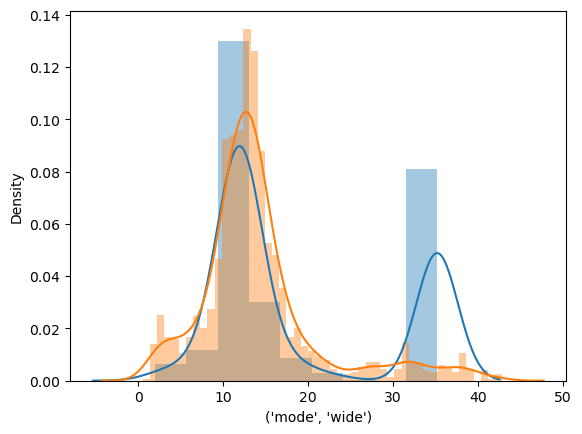

In [89]:
sns.distplot(tmp[('mode', 'narrow')])
sns.distplot(tmp[('mode', 'wide')])

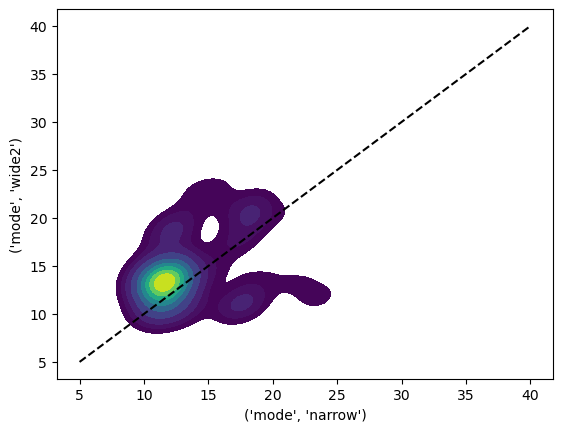

In [43]:
sns.kdeplot(data=tmp, x=('mode', 'narrow'), y=('mode', 'wide2'), fill=True, cmap='viridis')
plt.plot([5, 40], [5, 40], color='black', linestyle='--')

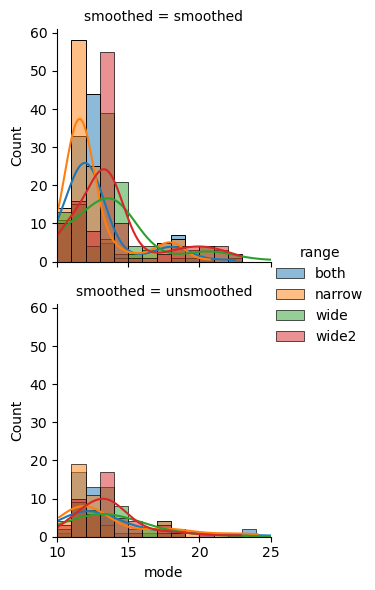

In [47]:
import seaborn as sns
import numpy as np

g = sns.FacetGrid(tmp.stack('range').reset_index(), hue='range', row='smoothed')
g.map(sns.histplot, 'mode', kde=True, bins=np.arange(10, 25,1))
g.add_legend()
g.set(xlim=(10, 25))

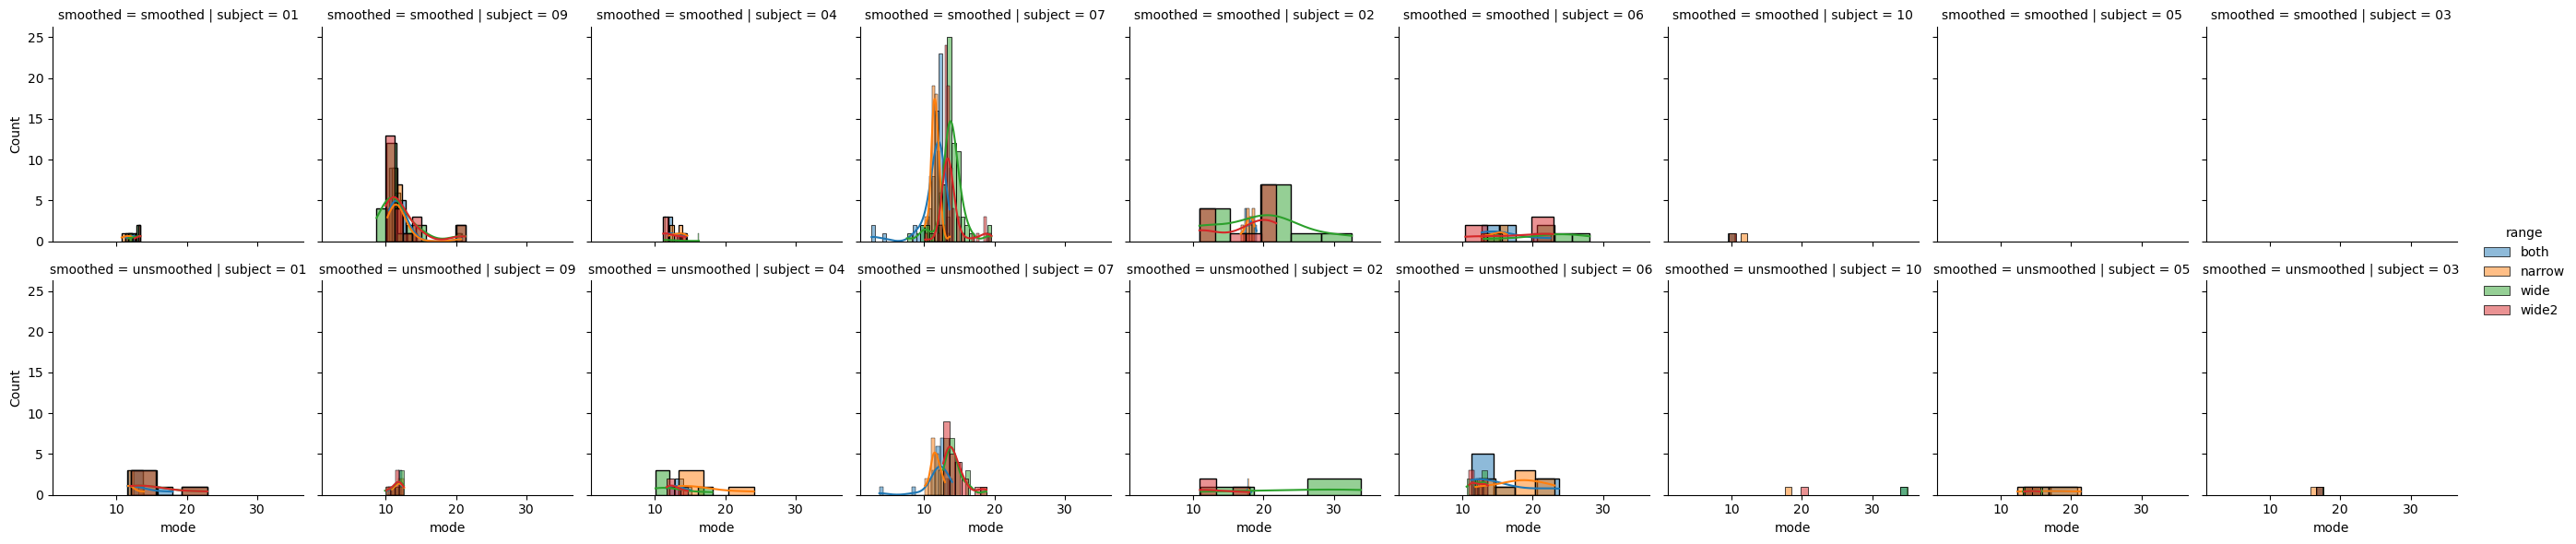

In [48]:
import seaborn as sns
g = sns.FacetGrid(tmp.stack('range').reset_index(), hue='range', col='subject', row='smoothed')
g.map(sns.histplot, 'mode', kde=True)
g.add_legend()

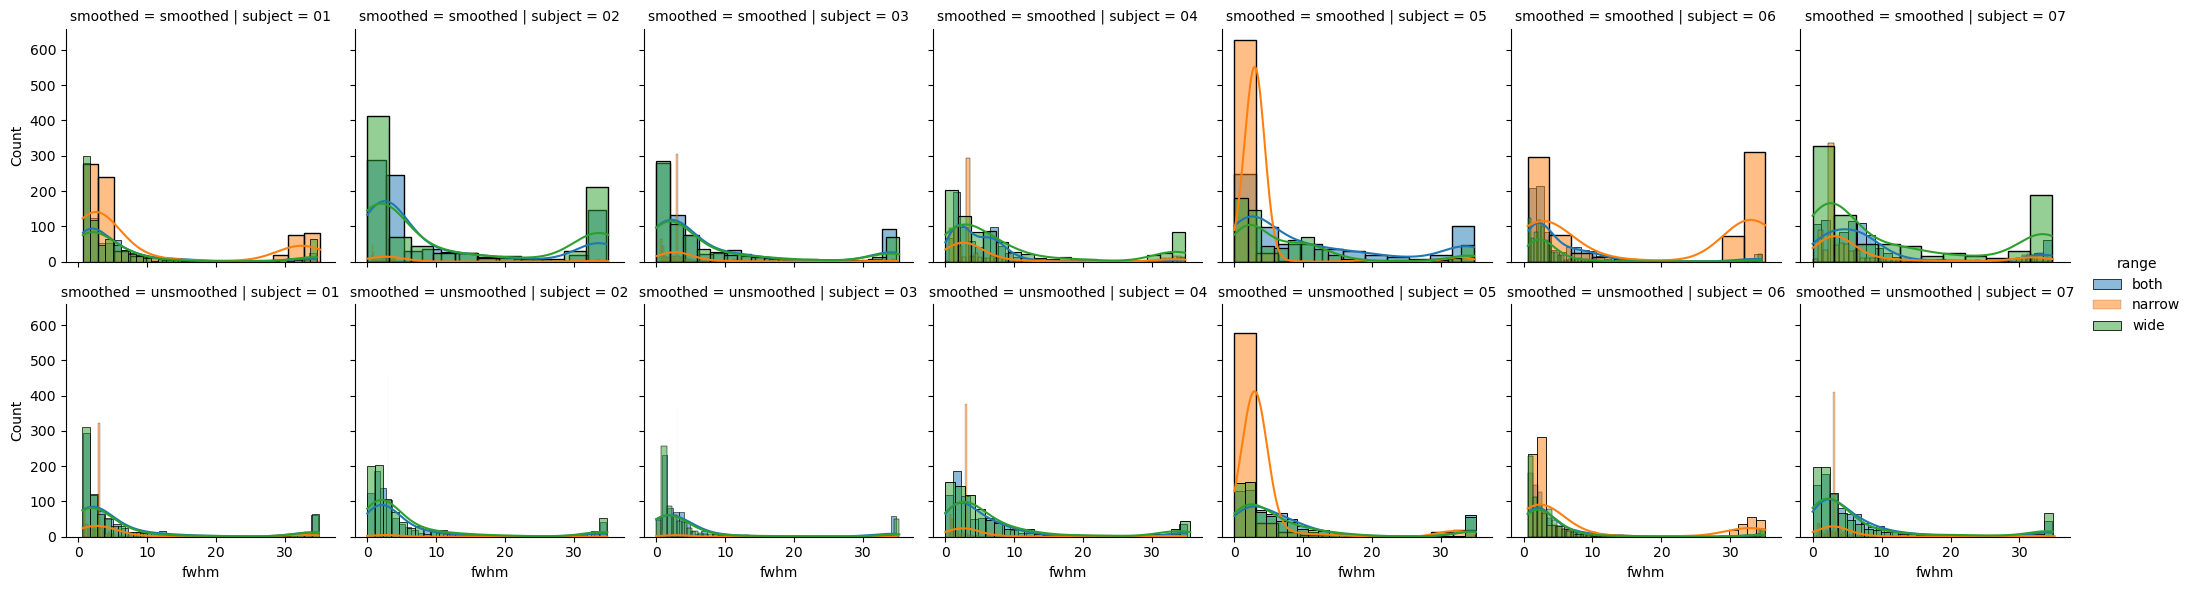

In [51]:
import seaborn as sns
g = sns.FacetGrid(tmp.stack('range').reset_index(), hue='range', col='subject', row='smoothed')
g.map(sns.histplot, 'fwhm', kde=True)
g.add_legend()

In [90]:
sns.catplot(x='range', y='amplitude', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/indexes/multi.py", line 1542, in _get_level_number
    level = self.names.index(level)
ValueError: 'range' is not in list

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_51312/2351929872.py", line 1, in <module>
    sns.catplot(x='range', y='amplitude', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True)
  File "/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/frame.py", line 9394, in stack
    result = stack(self, level, dropna=dropna, sort=sort)
  File "/Users/gdehol/mambaforge/lib/python3.

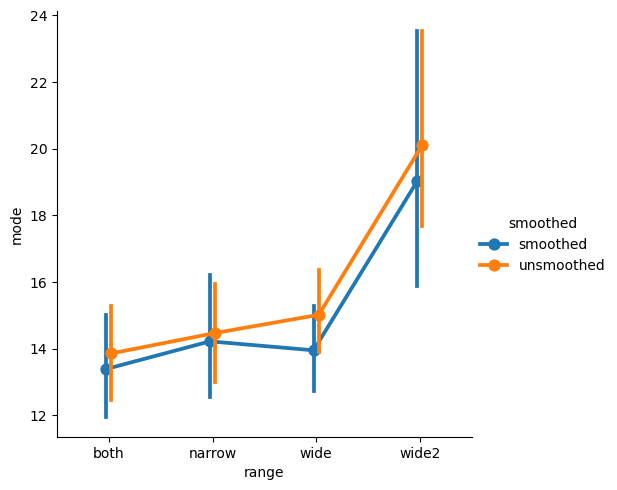

In [89]:
sns.catplot(x='range', y='mode', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True)

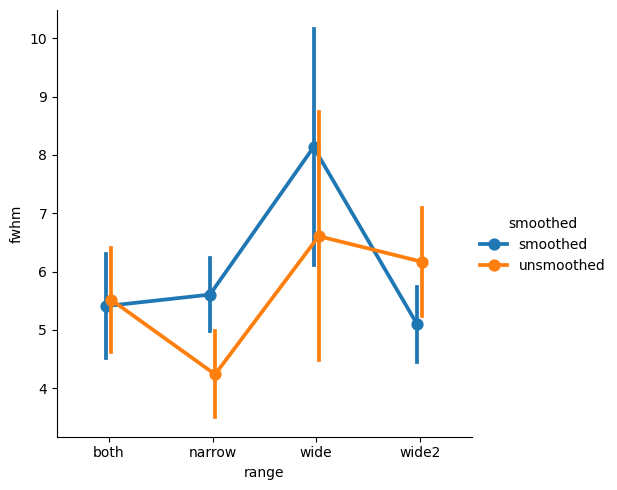

In [51]:
sns.catplot(x='range', y='fwhm', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True, errorbar='se')

(0.0, 40.0)

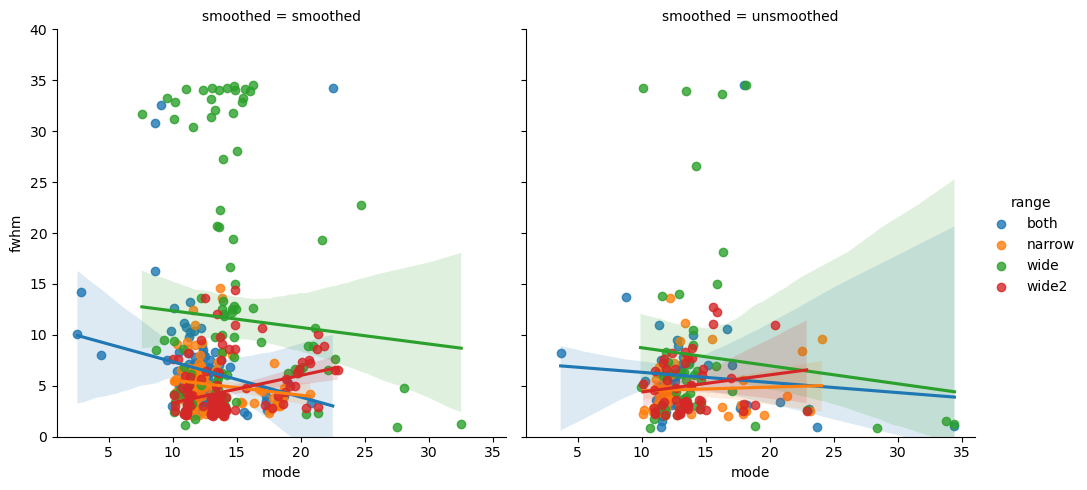

In [52]:
import matplotlib.pyplot as plt
sns.lmplot(x='mode', y='fwhm', data=tmp.stack('range').reset_index(), col='smoothed', hue='range')

plt.ylim(0, 40)

In [65]:
(tmp['mode'] < 25).all(1)

session  smoothed         subject
both     smoothed    0    01         False
                          02         False
                          03         False
                          04         False
                          05         False
                                     ...  
         unsmoothed  887  07         False
                     888  07          True
                     889  07          True
                     890  07         False
                     891  07          True
Length: 10988, dtype: bool

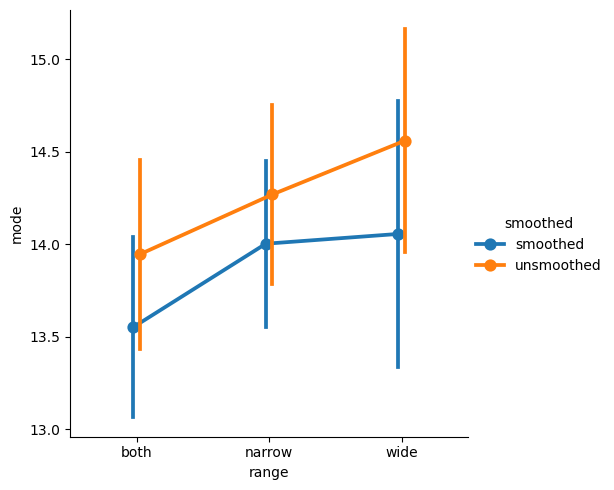

In [70]:
tmp = df.stack(['subject'])
tmp = tmp.loc[(tmp['mode'] < 25).all(1)]

sns.catplot(x='range', y='mode', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True,
            errorbar='se')

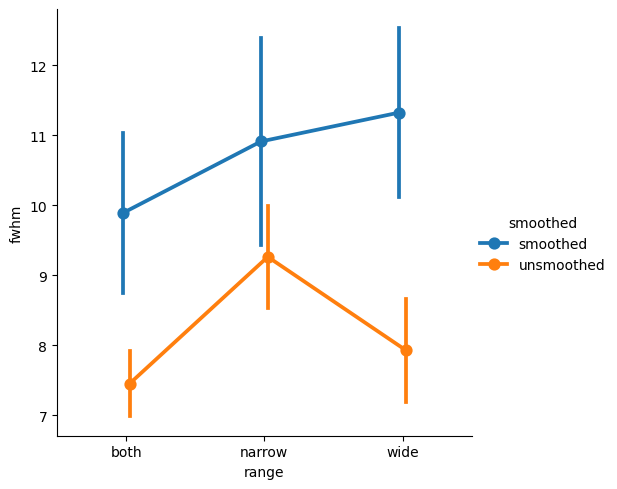

In [73]:
tmp = df.stack(['subject'])
tmp = tmp.loc[(tmp['mode'] < 25).all(1)]

sns.catplot(x='range', y='fwhm', data=tmp.stack('range').groupby(['subject', 'smoothed', 'range']).mean().reset_index(), kind='point', hue='smoothed', dodge=True,
            errorbar='se')

In [33]:
df['cvr2'].stack('subject').groupby(['subject']).apply(lambda d: d.corr())

range               wide    narrow      both
subject range                               
01      wide    1.000000  0.156808  0.590570
        narrow  0.156808  1.000000  0.391646
        both    0.590570  0.391646  1.000000
02      wide    1.000000  0.041252  0.459547
        narrow  0.041252  1.000000  0.294789
        both    0.459547  0.294789  1.000000
03      wide    1.000000  0.038834  0.355911
        narrow  0.038834  1.000000  0.242084
        both    0.355911  0.242084  1.000000
04      wide    1.000000  0.098691  0.632103
        narrow  0.098691  1.000000  0.296806
        both    0.632103  0.296806  1.000000
05      wide    1.000000  0.258374  0.702957
        narrow  0.258374  1.000000  0.420658
        both    0.702957  0.420658  1.000000
06      wide    1.000000  0.184195  0.562276
        narrow  0.184195  1.000000  0.385993
        both    0.562276  0.385993  1.000000
07      wide    1.000000  0.433093  0.695244
        narrow  0.433093  1.000000  0.643052
        both    0.695244  0.643052  1.000000

In [97]:
df['mode'].stack('subject').groupby(['subject', 'smoothed']).apply(lambda d: d.corr())

range                          wide    narrow      both
subject smoothed   range                               
01      smoothed   wide    1.000000  0.255567  0.576580
                   narrow  0.255567  1.000000  0.344114
                   both    0.576580  0.344114  1.000000
        unsmoothed wide    1.000000  0.134460  0.517123
                   narrow  0.134460  1.000000  0.265426
                   both    0.517123  0.265426  1.000000
02      smoothed   wide    1.000000  0.123189  0.529042
                   narrow  0.123189  1.000000  0.305775
                   both    0.529042  0.305775  1.000000
        unsmoothed wide    1.000000  0.039004  0.496808
                   narrow  0.039004  1.000000  0.172157
                   both    0.496808  0.172157  1.000000
03      smoothed   wide    1.000000  0.150447  0.575289
                   narrow  0.150447  1.000000  0.301796
                   both    0.575289  0.301796  1.000000
        unsmoothed wide    1.000000  0.231435  0.564900
                   narrow  0.231435  1.000000  0.429132
                   both    0.564900  0.429132  1.000000
04      smoothed   wide    1.000000  0.117579  0.586492
                   narrow  0.117579  1.000000  0.213618
                   both    0.586492  0.213618  1.000000
        unsmoothed wide    1.000000  0.120565  0.653789
                   narrow  0.120565  1.000000  0.242744
                   both    0.653789  0.242744  1.000000
05      smoothed   wide    1.000000  0.041145  0.482508
                   narrow  0.041145  1.000000  0.194150
                   both    0.482508  0.194150  1.000000
        unsmoothed wide    1.000000  0.009011  0.580497
                   narrow  0.009011  1.000000  0.109335
                   both    0.580497  0.109335  1.000000
06      smoothed   wide    1.000000  0.060599  0.582315
                   narrow  0.060599  1.000000  0.320384
                   both    0.582315  0.320384  1.000000
        unsmoothed wide    1.000000  0.073477  0.553875
                   narrow  0.073477  1.000000  0.218845
                   both    0.553875  0.218845  1.000000
07      smoothed   wide    1.000000  0.200234  0.448641
                   narrow  0.200234  1.000000  0.250176
                   both    0.448641  0.250176  1.000000
        unsmoothed wide    1.000000  0.118196  0.566392
                   narrow  0.118196  1.000000  0.273493
                   both    0.566392  0.273493  1.000000